# **SETUP**
All necessary libraries are imported here.

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, Rescaling, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# **DATASET ANALYSIS**
This block inspects the dataset to understand its structure and class distribution.

In [11]:
def count_images(dataset_path):
    """Counts images in train, test, and validation splits."""
    counts = {}
    for split in ["train", "test", "val"]:
        split_path = os.path.join(dataset_path, split)
        if not os.path.isdir(split_path): continue
        counts[split] = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if not f.startswith('.')])
                counts[split][class_name] = num_images
    return counts

# Print the image counts for each split and class
dataset_dir = "dataset"
image_counts = count_images(dataset_dir)
for split, classes in image_counts.items():
    print(f"\n{split.upper()}:")
    for cls, num in classes.items():
        print(f"  {cls}: {num} images")


TRAIN:
  anemia: 1627 images
  non-anemia: 280 images

TEST:
  anemia: 227 images
  non-anemia: 35 images

VAL:
  anemia: 453 images
  non-anemia: 80 images


# **CONFIGURATION AND DATA LOADING**
Define constants and load the datasets correctly.

In [12]:
# --- Configuration ---
TRAIN_DIR = "dataset/train"
VAL_DIR = "dataset/val"
TEST_DIR = "dataset/test"
BATCH_SIZE = 8
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

# --- Load Datasets ---
# Load an UNBATCHED dataset first to get class names and labels for weighting
unbatched_train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=None  # Load as individual files
)

# Load final BATCHED datasets for training and evaluation
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    VAL_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = image_dataset_from_directory(
    TEST_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# --- Confirm Class Mapping ---
class_names = train_ds.class_names
print(f"\n✅ Class names found: {class_names}")
print(f"➡️ '{class_names[0]}' is mapped to class 0")
print(f"➡️ '{class_names[1]}' is mapped to class 1")

Found 1907 files belonging to 2 classes.
Found 1907 files belonging to 2 classes.
Found 533 files belonging to 2 classes.
Found 262 files belonging to 2 classes.

✅ Class names found: ['anemia', 'non-anemia']
➡️ 'anemia' is mapped to class 0
➡️ 'non-anemia' is mapped to class 1


# **DATA PREPARATION (PIPELINE AND CLASS WEIGHTS)**
Configure the data pipeline for performance and calculate class weights.

In [13]:
# --- Configure Data Pipeline ---
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("\n✅ Data pipeline configured for performance.")

# --- Calculate Class Weights ---
# Extract labels from the unbatched dataset
train_labels = np.array([y.numpy() for x, y in unbatched_train_ds])

# Calculate weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights calculated: {class_weight_dict}")


✅ Data pipeline configured for performance.
✅ Class weights calculated: {0: np.float64(0.5860479409956976), 1: np.float64(3.405357142857143)}


# **MODEL DEFINITION**
Define the model architecture using a pre-trained base and a custom head.

In [14]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
], name='data_augmentation')

# --- Base Model (MobileNetV2) ---
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False # Freeze the base model initially

# --- Final Model Assembly ---
model = tf.keras.Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,
    Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation="sigmoid", kernel_regularizer=l2(0.001))
])

# --- Compile the Model ---
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

print("\n✅ Model defined and compiled.")
model.summary()

C:\Users\LAPTOP MSI\AppData\Local\Temp\ipykernel_1464\3358742644.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(



✅ Model defined and compiled.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **STAGE 1 TRAINING (FEATURE EXTRACTION)**
Train the custom head of the model with the base model frozen.

In [15]:
print("\n--- Starting Training Stage 1: Feature Extraction ---")
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[es],
    class_weight=class_weight_dict
)


--- Starting Training Stage 1: Feature Extraction ---
Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - accuracy: 0.8259 - loss: 0.3676 - val_accuracy: 0.9475 - val_loss: 0.1561
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.9423 - loss: 0.1564 - val_accuracy: 0.9512 - val_loss: 0.1434
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.9601 - loss: 0.1204 - val_accuracy: 0.9531 - val_loss: 0.1382
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 49s 205ms/step - accuracy: 0.9722 - loss: 0.0897 - val_accuracy: 0.9531 - val_loss: 0.1362
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.9764 - loss: 0.0841 - val_accuracy: 0.9174 - val_loss: 0.1901
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.9754 - loss: 0.0915 - val_accuracy: 0.9381 - val_loss: 0.1468
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 215ms/step - accuracy: 0.9780 - loss: 0.0727 - val_accuracy: 0.8893 - val_loss: 0.2623
Epoch 8/15
239/239 ━━━━━━━━━

# **STAGE 2 TRAINING (FINE-TUNING)**
Unfreeze some layers of the base model and continue training with a lower learning rate.

In [ ]:
print("\n--- Starting Training Stage 2: Fine-Tuning ---")
# --- Unfreeze Layers ---
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# --- Re-compile with a lower learning rate ---
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# --- Define additional callback for learning rate reduction ---
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

# --- Continue Training ---
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[es, reduce_lr],
    class_weight=class_weight_dict
)
print("\n--- Training Complete ---")


--- Starting Training Stage 2: Fine-Tuning ---
Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 285ms/step - accuracy: 0.9460 - loss: 0.2928 - val_accuracy: 0.9400 - val_loss: 0.1542 - learning_rate: 1.0000e-05
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 61s 254ms/step - accuracy: 0.9428 - loss: 0.1733 - val_accuracy: 0.9437 - val_loss: 0.1499 - learning_rate: 1.0000e-05
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 61s 255ms/step - accuracy: 0.9518 - loss: 0.1425 - val_accuracy: 0.9418 - val_loss: 0.1383 - learning_rate: 1.0000e-05
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 63s 263ms/step - accuracy: 0.9612 - loss: 0.1210 - val_accuracy: 0.9306 - val_loss: 0.1517 - learning_rate: 1.0000e-05
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 60s 252ms/step - accuracy: 0.9601 - loss: 0.1052 - val_accuracy: 0.9456 - val_loss: 0.1390 - learning_rate: 1.0000e-05

--- Training Complete ---


In [17]:
# --- Save the final model ---
model.save("anemia_model.keras")
print("\n✅ Final model saved to anemia_classifier_model.keras")


✅ Final model saved to anemia_classifier_model.keras


# **In số liệu model**


--- Evaluating Final Model ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.7901 - loss: 0.3882
Test Accuracy: 0.79
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step

Classification Report:
              precision    recall  f1-score   support

      anemia       0.97      0.78      0.87       227
  non-anemia       0.37      0.83      0.51        35

    accuracy                           0.79       262
   macro avg       0.67      0.81      0.69       262
weighted avg       0.89      0.79      0.82       262



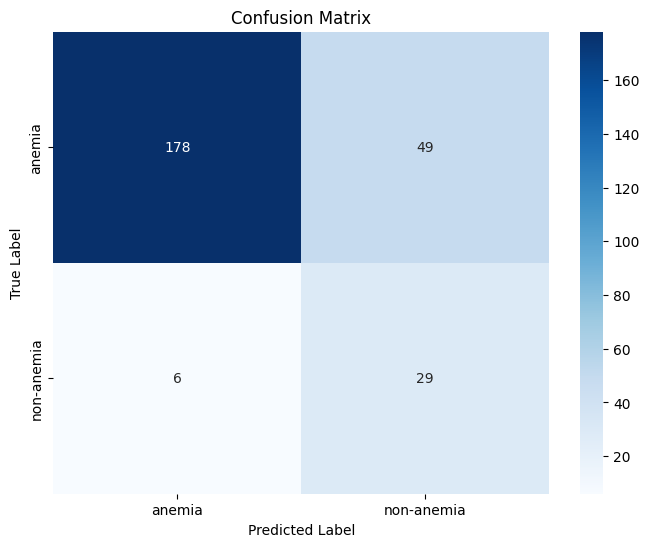

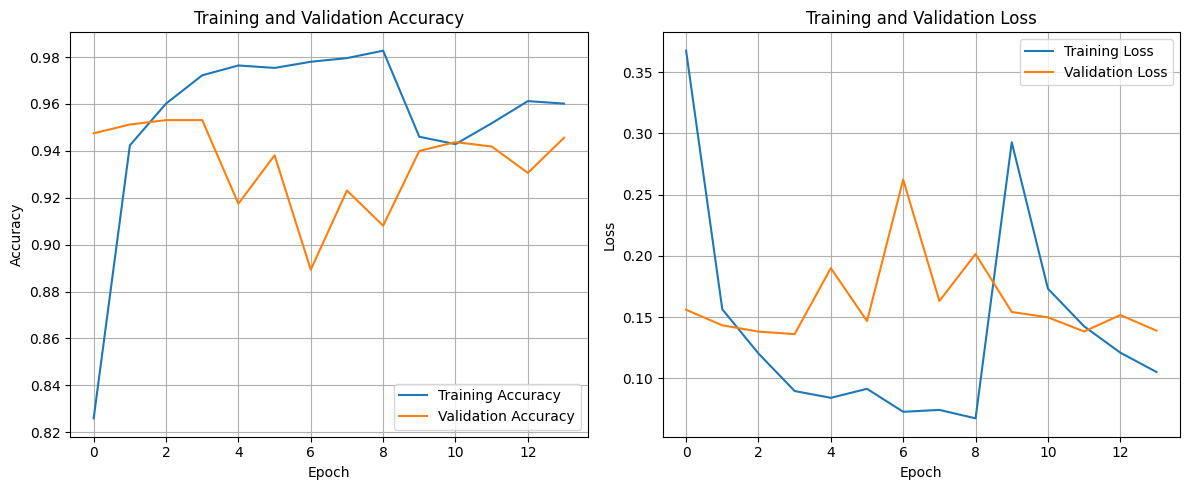

In [18]:
# --- 1. Vẽ biểu đồ Loss và Accuracy ---
print("\n--- Evaluating Final Model ---")

# --- Evaluate on Test Data ---
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# --- Generate Predictions ---
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# --- Get True Labels ---
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Plot Training History ---
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()